In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Wed Jun 24 10:44:07 PDT 2020


In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/00_bugfix/india_new_start_date/count_data/']

locations = ['India']

In [3]:
deaths = pd.read_hdf(output_dirs[0] + 'deaths.hdf')
deaths = deaths.groupby(['age_group','sex','input_draw','scenario']).sum()
deaths.head() 

value
age_group sex    input_draw scenario                               
1_to_4    female 357        baseline                           91.0
                            iron_fortification_scale_up        91.0
                            vitamin_a_fortification_scale_up   88.0
                 602        baseline                           84.0
                            iron_fortification_scale_up        84.0

In [4]:
pt = pd.read_hdf(output_dirs[0] + 'person_time.hdf')
pt = pt.groupby (['age_group','sex','input_draw','scenario']).sum()
pt.head()

value
age_group sex    input_draw scenario                                      
1_to_4    female 357        baseline                          35984.236055
                            iron_fortification_scale_up       35984.236055
                            vitamin_a_fortification_scale_up  35997.816995
                 602        baseline                          35934.670409
                            iron_fortification_scale_up       35934.670409

In [5]:
acmr = deaths / pt
acmr = acmr.reset_index()
acmr = acmr.loc[acmr.scenario == 'baseline']
acmr['sex'] = np.where(acmr['sex'] == 'female', 'Female', 'Male')
acmr = acmr.set_index(['sex','age_group']).sort_index().reset_index()
acmr.head()

,sex,age_group,input_draw,scenario,value
0,Female,1_to_4,357,baseline,0.002529
1,Female,1_to_4,602,baseline,0.002338
2,Female,1_to_4,650,baseline,0.002087
3,Female,1_to_4,829,baseline,0.002864
4,Female,1_to_4,946,baseline,0.002419


In [6]:
art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/india.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
data = art.load('cause.all_causes.cause_specific_mortality_rate')
data_mean = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'value'})
data_mean.head()

value
location sex    age_start age_end  year_start year_end          
India    Female 0.000000  0.019178 2017       2018      0.903030
                0.019178  0.076712 2017       2018      0.093716
                0.076712  1.000000 2017       2018      0.015371
                1.000000  5.000000 2017       2018      0.001737
         Male   0.000000  0.019178 2017       2018      1.012133

In [7]:
art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/india.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
data = art.load('cause.all_causes.cause_specific_mortality_rate')
data_mean = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'value'})
data_limits = pd.DataFrame(data.quantile([0.0,1], axis=1)).transpose().rename(columns={0.0:'lower',
                                                                                             1:'upper'})
data = data_mean.merge(data_limits, right_index=True, left_index=True).reset_index()
data['age_group'] = 0
data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                       np.where(data['age_end'] == 1, 'post_neonatal',
                                np.where(data['age_start'] == 1, '1_to_4', 
                                        'late_neonatal')))
data

,location,sex,age_start,age_end,year_start,year_end,value,lower,upper,age_group
0,India,Female,0.000000,0.019178,2017,2018,0.903030,0.826478,0.997342,early_neonatal
1,India,Female,0.019178,0.076712,2017,2018,0.093716,0.086097,0.102730,late_neonatal
2,India,Female,0.076712,1.000000,2017,2018,0.015371,0.014059,0.017052,post_neonatal
3,India,Female,1.000000,5.000000,2017,2018,0.001737,0.001436,0.002045,1_to_4
4,India,Male,0.000000,0.019178,2017,2018,1.012133,0.934420,1.107655,early_neonatal
5,India,Male,0.019178,0.076712,2017,2018,0.074361,0.068296,0.081276,late_neonatal
6,India,Male,0.076712,1.000000,2017,2018,0.012091,0.011133,0.013314,post_neonatal
7,India,Male,1.000000,5.000000,2017,2018,0.001322,0.001095,0.001559,1_to_4


In [8]:
data = data.set_index(['sex','age_group']).sort_index().reset_index()
data

,sex,age_group,location,age_start,age_end,year_start,year_end,value,lower,upper
0,Female,1_to_4,India,1.000000,5.000000,2017,2018,0.001737,0.001436,0.002045
1,Female,early_neonatal,India,0.000000,0.019178,2017,2018,0.903030,0.826478,0.997342
2,Female,late_neonatal,India,0.019178,0.076712,2017,2018,0.093716,0.086097,0.102730
3,Female,post_neonatal,India,0.076712,1.000000,2017,2018,0.015371,0.014059,0.017052
4,Male,1_to_4,India,1.000000,5.000000,2017,2018,0.001322,0.001095,0.001559
5,Male,early_neonatal,India,0.000000,0.019178,2017,2018,1.012133,0.934420,1.107655
6,Male,late_neonatal,India,0.019178,0.076712,2017,2018,0.074361,0.068296,0.081276
7,Male,post_neonatal,India,0.076712,1.000000,2017,2018,0.012091,0.011133,0.013314


In [9]:
for data_set in [acmr, data]:
    data_set['age_group_order'] = np.where(data_set['age_group'] == 'early_neonatal', 1,
                                          np.where(data_set['age_group'] == 'late_neonatal', 2,
                                                  np.where(data_set['age_group'] == 'post_neonatal', 3,
                                                          np.where(data_set['age_group'] == '1_to_4', 4, 0))))
    
acmr = acmr.set_index(['sex','age_group_order']).sort_index().reset_index()
data = data.set_index(['sex','age_group_order']).sort_index().reset_index()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


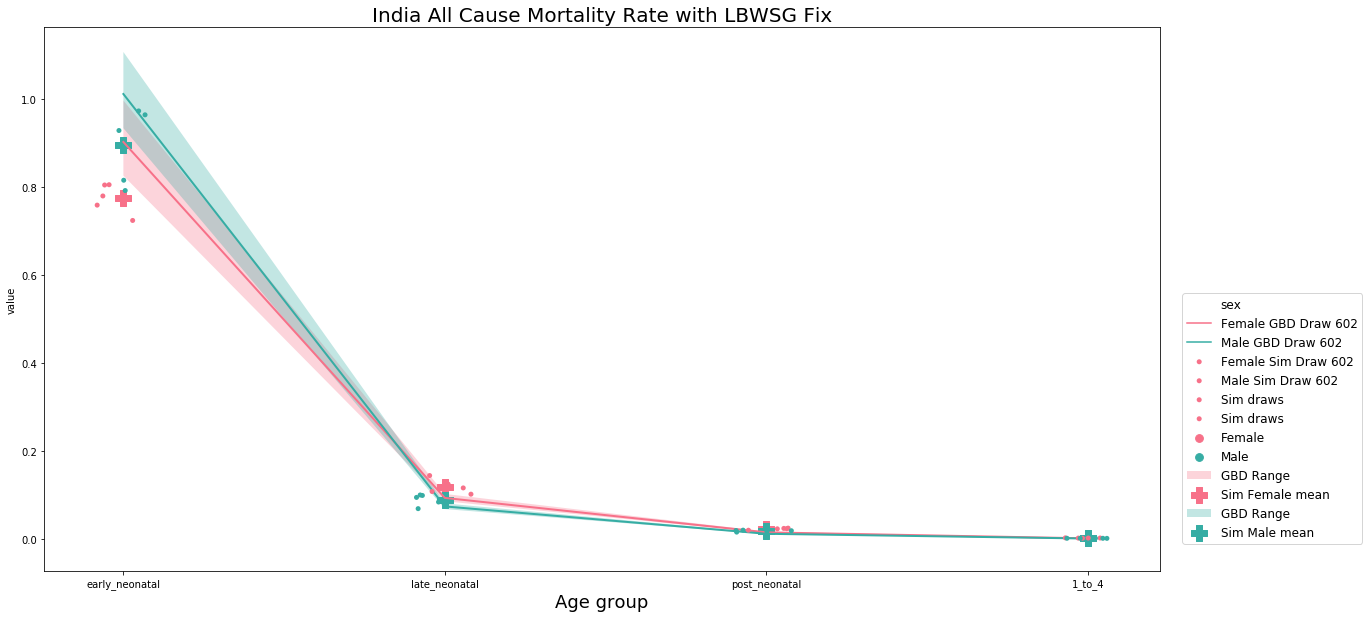

In [10]:
measure_s = acmr
measure_m = acmr.groupby(['sex','age_group'],as_index=False).mean().sort_values(by=['sex','age_group_order'])
measure_g = data

fig, ax = plt.subplots(figsize=(20, 10))
clrs = sns.color_palette('husl', 2)

sns.lineplot(x='age_group', y='value', hue='sex', palette=clrs, 
         linewidth=2, ax=ax, data=measure_g, sort=False)

g1 = sns.catplot(x='age_group', y='value', ax=ax, data=measure_s, hue='sex',
                 palette=clrs, label='Sim draws')

for i, sex in enumerate(['Female','Male']):
    sex_g = measure_g.loc[measure_g.sex == sex]
    ax.fill_between(sex_g.age_group.values, sex_g.upper, sex_g.lower, alpha=0.3, label='GBD Range', facecolor=clrs[i])

    sex_m = measure_m.loc[measure_m.sex == sex]
    ax.scatter(sex_m.age_group, sex_m.value, s=250, marker='P', 
           label=f'Sim {sex} mean', c=clrs[i])

ax.set_title('India All Cause Mortality Rate with LBWSG Fix', fontsize=20)
ax.set_xlabel('Age group', fontsize=18)

l = ax.legend(loc=(1.02, 0.05), fontsize=12)
labels = ['Female GBD Draw 602','Male GBD Draw 602','Female Sim Draw 602','Male Sim Draw 602']
for text, label in zip(l.texts[1:5], labels):
    text.set_text(label)
plt.close(g1.fig)

In [11]:
measure_m

,sex,age_group,age_group_order,input_draw,value
1,Female,early_neonatal,1.0,676.8,0.775096
2,Female,late_neonatal,2.0,676.8,0.119269
3,Female,post_neonatal,3.0,676.8,0.023320
0,Female,1_to_4,4.0,676.8,0.002447
5,Male,early_neonatal,1.0,676.8,0.895254
6,Male,late_neonatal,2.0,676.8,0.089622
7,Male,post_neonatal,3.0,676.8,0.018421
4,Male,1_to_4,4.0,676.8,0.001858


In [12]:
measure_g

,sex,age_group_order,age_group,location,age_start,age_end,year_start,year_end,value,lower,upper
0,Female,1,early_neonatal,India,0.000000,0.019178,2017,2018,0.903030,0.826478,0.997342
1,Female,2,late_neonatal,India,0.019178,0.076712,2017,2018,0.093716,0.086097,0.102730
2,Female,3,post_neonatal,India,0.076712,1.000000,2017,2018,0.015371,0.014059,0.017052
3,Female,4,1_to_4,India,1.000000,5.000000,2017,2018,0.001737,0.001436,0.002045
4,Male,1,early_neonatal,India,0.000000,0.019178,2017,2018,1.012133,0.934420,1.107655
5,Male,2,late_neonatal,India,0.019178,0.076712,2017,2018,0.074361,0.068296,0.081276
6,Male,3,post_neonatal,India,0.076712,1.000000,2017,2018,0.012091,0.011133,0.013314
7,Male,4,1_to_4,India,1.000000,5.000000,2017,2018,0.001322,0.001095,0.001559
